# モジュールをインポート

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# 学習歴史を読み込み

In [3]:
with open("./training_keras_hist_2019_11_21/train_hist", "rb") as file:
    history = pickle.load(file)

In [4]:
history.keys()

dict_keys(['val_acc', 'acc', 'loss', 'val_loss'])

# 学習正解率を描画

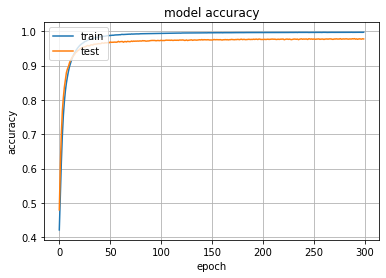

In [5]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

# 学習損失を描画

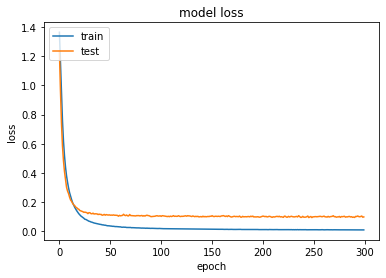

In [6]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# テストデータセットを読み込み

In [7]:
dataset_dir = "./preprocessed_dataset/"

with open(dataset_dir+"1_2_shuffle_dataset_3D_win_10.pkl", "rb") as fp:
  	dataset = pickle.load(fp)
with open(dataset_dir+"1_2_shuffle_labels_3D_win_10.pkl", "rb") as fp:
  	labels = pickle.load(fp)
dataset = dataset.reshape(len(dataset), 10, 10, 11, 1)
print("Dataset shape:", dataset.shape)
print("Labels shape:", labels.shape)

Dataset shape: (11717, 10, 10, 11, 1)
Labels shape: (11717,)


# ラベルエンコーディング

In [8]:
def one_hot_encoder(labels):
    return np.asarray(pd.get_dummies(labels), dtype = np.int8)
labels = one_hot_encoder(labels)
print("One-hot-encoded labels:")
print(labels)

One-hot-encoded labels:
[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]]


In [9]:
X_test = dataset 
y_test = labels

print("Test dataset shape:", X_test.shape)
print("Test label shape:", y_test.shape)

Test dataset shape: (11717, 10, 10, 11, 1)
Test label shape: (11717, 5)


# モデルを定義

In [10]:
dropout_prob = 0.5
n_labels = y_test.shape[1]
training_epochs = 10
batch_size = 300
learning_rate = 1e-4

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Conv2D, Conv3D
from tensorflow.keras.layers import Reshape, Flatten, Softmax
from tensorflow.keras.optimizers import Adam

def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    X_input = Input(shape = input_shape)

    conv_1 = Conv3D(filters=32, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1), activation="elu")(X_input)
    conv_2 = Conv3D(filters=64, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1), activation="elu")(conv_1)
    conv_3 = Conv3D(filters=128, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1), activation="elu")(conv_2)
    shape = conv_3.get_shape().as_list()
    
    pool_2_flat = Reshape([shape[1], shape[2]*shape[3]*shape[4]])(conv_3)
    fc = Dense(1024, activation="elu")(pool_2_flat)
    fc_drop = Dropout(dropout_prob)(fc)
    
    lstm_in = Reshape([10, 1024])(fc_drop)
    lstm_1 = LSTM(units=1024, return_sequences=True, unit_forget_bias=True, dropout=dropout_prob)(lstm_in)
    rnn_output = LSTM(units=1024, return_sequences=False, unit_forget_bias=True)(lstm_1)
    
    shape_rnn_out = rnn_output.get_shape().as_list()
    fc_out = Dense(shape_rnn_out[1], activation="elu")(rnn_output)
    fc_drop = Dropout(dropout_prob)(fc_out)
    y_ = Dense(n_labels)(fc_drop)
    y_posi = Softmax()(y_)
#     X = Argmax()(X)
#     X = argmax()(X)
#     X = Dense(5, activation="elu")(X)
    
    
    model = Model(inputs = X_input, outputs = y_posi)
    return model

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [11]:
model = model(input_shape = (X_test.shape[1], X_test.shape[2], X_test.shape[3], X_test.shape[4]))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# モデルの確認

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 10, 11, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 10, 10, 11, 32)    896       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 10, 11, 64)    55360     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 10, 11, 128)   221312    
_________________________________________________________________
reshape (Reshape)            (None, 10, 14080)         0         
_________________________________________________________________
dense (Dense)                (None, 10, 1024)          14418944  
_________________________________________________________________
dropout (Dropout)            (None, 10, 1024)          0     

In [13]:
opt = Adam(lr=learning_rate)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

## 学習済みモデルの重みを読み込み

In [14]:
checkpoint_path = "training_keras_2019_11_21/cp.ckpt"
model.load_weights(checkpoint_path)

# Load data stream

In [15]:
from pylsl import StreamInlet, resolve_byprop
from muselsl.constants import LSL_SCAN_TIMEOUT, LSL_EEG_CHUNK

LSL_EEG_CHUNK = 10
def record_stream():
    """
    :return: a generator to fetch EEG data from existed stream.
    """
    streams = resolve_byprop("type", "EEG", timeout=LSL_SCAN_TIMEOUT)
    if len(streams) == 0:
        raise IOError("Can't find EEG stream.")

    inlet = StreamInlet(streams[0], max_buflen=LSL_EEG_CHUNK)

    info = inlet.info()
    description = info.desc()
    Nchan = info.channel_count()

    ch = description.child('channels').first_child()
    ch_names = [ch.child_value("label")]
    for i in range(1, Nchan):
        ch = ch.next_sibling()
        ch_names.append(ch.child_value('label'))
#     print(ch_names)
    while True:
        yield inlet.pull_chunk(timeout=1.0, max_samples=LSL_EEG_CHUNK)


In [16]:
print("['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX']")
print(np.array(next(record_stream())[0])[:, 0:4])

['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX']
[[ -398.4375      -467.28515625    -8.30078125  -447.75390625]
 [ -879.39453125   999.0234375   -123.53515625   606.4453125 ]
 [  291.50390625   575.68359375   -19.53125      383.7890625 ]
 [-1000.          -851.5625        98.14453125  -662.59765625]
 [ -858.88671875  -829.58984375    37.59765625  -661.1328125 ]
 [  739.2578125    580.078125    -100.09765625   357.421875  ]
 [  576.171875     872.55859375   -58.59375      601.5625    ]
 [ -939.453125    -506.34765625    88.37890625  -518.06640625]
 [-1000.          -990.234375      62.01171875  -892.08984375]
 [   59.5703125    199.21875      -65.91796875   -15.625     ]]


# Preprocessing

In [17]:
def data_1Dto2D(data, Y=10, X=11):
    data_2D = np.zeros([Y, X])
    data_2D[1, 3] = data[1]
    data_2D[1, 7] = data[2]
    data_2D[5, 1] = data[0]
    data_2D[5, 8] = data[3]
# 	data_2D[0] = ( 	   	 0, 	   0,  	   	 0, 	   0,        0,        0,        0, 	   0,  	     0, 	   0, 	 	 0) 
# 	data_2D[1] = (	  	 0, 	   0,  	   	 0, data[1],        0,        0,        0, data[2], 	   	 0,   	   0, 	 	 0) 
# 	data_2D[2] = (	  	 0,        0,        0,        0,        0,        0,        0,        0,        0,        0, 	 	 0) 
# 	data_2D[3] = (	  	 0,        0,        0,        0,        0,        0,        0,        0,        0,        0, 		 0) 
# 	data_2D[4] = (       0,        0,        0,        0,        0,        0,        0,        0,        0,        0,        0) 
# 	data_2D[5] = (	  	 0, data[0],        0,        0,        0,        0,        0,        0,        0, data[3], 		 0) 
# 	data_2D[6] = (	  	 0,        0,        0,        0,        0,        0,        0,        0,        0,        0, 		 0) 
# 	data_2D[7] = (	  	 0, 	   0, 	 	 0,        0,        0,        0,        0,        0, 	   	 0, 	   0, 		 0) 
# 	data_2D[8] = (	  	 0, 	   0, 	 	 0, 	   0,        0,        0,        0, 	   0, 	   	 0, 	   0, 		 0) 
# 	data_2D[9] = (	  	 0, 	   0, 	 	 0, 	   0, 	     0,        0, 		 0, 	   0, 	   	 0, 	   0, 		 0) 
    return data_2D

In [18]:
buffer_2d = np.zeros((10, 10, 11))
print(buffer_2d[0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [19]:
for i in next(record_stream())[0]:
    num = 0
    buffer_2d[num, 1, 3] = i[1]
    buffer_2d[num, 1, 7] = i[2]
    buffer_2d[num, 5, 1] = i[0]
    buffer_2d[num, 5, 9] = i[3]

In [20]:
print(buffer_2d[0])

[[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.        ]
 [   0.            0.            0.          896.97265625    0.
     0.            0.          -23.4375        0.            0.
     0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.        ]
 [   0.         -873.046875      0.            0.            0.
     0.            0.            0.            0.          513.671875
     0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.           

In [21]:
X_test = buffer_2d.reshape((1, 10, 10, 11, 1))

In [22]:
for stream in record_stream():
    buffer_2d = np.zeros((10, 10, 11))
#     print(stream[0])
    for i in next(record_stream())[0]:
        num = 0
        buffer_2d[num, 1, 3] = i[1]
        buffer_2d[num, 1, 7] = i[2]
        buffer_2d[num, 5, 1] = i[0]
        buffer_2d[num, 5, 9] = i[3]
    X_test = buffer_2d.reshape((1, 10, 10, 11, 1))
    y_pred = model.predict(X_test, batch_size=1, verbose=1)
    y_pred_bool = np.argmax(y_pred, axis=1)
    true_labels = ['eye_close', 'image_open&close_both_feet',
       'image_open&close_both_fists', 'image_open&close_left_fist',
       'image_open&close_right_fist']
    print(true_labels[int(y_pred_bool)])

1/1 [==============================] - 1s 1s/sample
image_open&close_both_feet
1/1 [==============================] - 0s 32ms/sample
image_open&close_both_feet
1/1 [==============================] - 0s 38ms/sample
eye_close
1/1 [==============================] - 0s 37ms/sample
eye_close
1/1 [==============================] - 0s 35ms/sample
image_open&close_both_fists
1/1 [==============================] - 0s 36ms/sample
eye_close
1/1 [==============================] - 0s 38ms/sample
image_open&close_both_feet
1/1 [==============================] - 0s 38ms/sample
eye_close
1/1 [==============================] - 0s 32ms/sample
eye_close
1/1 [==============================] - 0s 37ms/sample
image_open&close_left_fist
1/1 [==============================] - 0s 30ms/sample
eye_close
1/1 [==============================] - 0s 39ms/sample
image_open&close_both_feet
1/1 [==============================] - 0s 38ms/sample
image_open&close_both_feet
1/1 [==============================] - 0s 34ms/sam

image_open&close_both_fists
1/1 [==============================] - 0s 38ms/sample
eye_close
1/1 [==============================] - 0s 31ms/sample
image_open&close_both_feet
1/1 [==============================] - 0s 38ms/sample
eye_close
1/1 [==============================] - 0s 38ms/sample
eye_close
1/1 [==============================] - 0s 38ms/sample
eye_close
1/1 [==============================] - 0s 38ms/sample
eye_close
1/1 [==============================] - 0s 30ms/sample
eye_close
1/1 [==============================] - 0s 38ms/sample
eye_close
1/1 [==============================] - 0s 30ms/sample
image_open&close_both_feet
1/1 [==============================] - 0s 38ms/sample
eye_close
1/1 [==============================] - 0s 36ms/sample
eye_close
1/1 [==============================] - 0s 38ms/sample
eye_close
1/1 [==============================] - 0s 38ms/sample
eye_close
1/1 [==============================] - 0s 38ms/sample
eye_close
1/1 [==============================] - 0s 

KeyboardInterrupt: 

# テストデータを分類

In [ ]:
y_pred = model.predict(X_test, batch_size=1, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

In [ ]:
print("サンプリング率:", 160)
print("1秒に処理できる信号数：", 990*10-6)

In [ ]:
y_pred_bool = one_hot_encoder(y_pred_bool)
y_pred_bool

# 精度と正解率の曲線

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize

precision = dict()
recall = dict()
for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred_bool[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

# 分類結果

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_bool))

In [ ]:
print("検証正解率：", history["val_acc"][-1])

In [ ]:
from sklearn.metrics import accuracy_score
print("テスト正解率：", accuracy_score(y_test, y_pred_bool))